In [135]:
from tensorflow.keras import backend as K
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.preprocessing import image
import tensorflow as tf

import numpy as np
import scipy

In [136]:
tf.__version__

'1.14.0'

In [137]:
K.set_learning_phase(0)

In [138]:
model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False)

In [139]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5':1.5,
}

In [140]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [141]:
layer_dict

{'input_6': <tensorflow.python.keras.engine.input_layer.InputLayer at 0x7f22fa5f40d0>,
 'conv2d_282': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f22fa5e7310>,
 'batch_normalization_282': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7f22fa5f4b90>,
 'activation_282': <tensorflow.python.keras.layers.core.Activation at 0x7f22fa5f4710>,
 'conv2d_283': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f22fc18a890>,
 'batch_normalization_283': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7f22fa58db10>,
 'activation_283': <tensorflow.python.keras.layers.core.Activation at 0x7f22fa543f50>,
 'conv2d_284': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f22fa543ed0>,
 'batch_normalization_284': <tensorflow.python.keras.layers.normalization.BatchNormalization at 0x7f22fa503e10>,
 'activation_284': <tensorflow.python.keras.layers.core.Activation at 0x7f22fa521f50>,
 'max_pooling2d_12': <tensorflow.python.keras.lay

In [142]:
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2 : -2, 2: -2, :])) / scaling

In [143]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]

In [144]:
def eval_loss_and_grads(x):
    
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    
    return loss_value, grad_values

In [145]:
def gradient_ascent(x, iterations, step, max_loss=None):
    
    for i in range(iterations):
        
        loss_value, grad_values = eval_loss_and_grads(x)
        
        if max_loss is not None and loss_value > max_loss:
            break
            
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
        
    return x

In [146]:
def resize_img(img, size):
    
    img = np.copy(img)
    
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    
    return scipy.ndimage.zoom(img, factors, order=1)

In [147]:
def preprocess_image(image_path):

    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    
    return img

In [148]:
def deprocess_image(x):

    if K.image_data_format() == 'channels_first':
        
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
        
    else:
        
        x = x.reshape((x.shape[1], x.shape[2], 3))
        
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [149]:
def save_img(img, fname):
    
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

In [173]:
step = 0.01
num_octave = 5
octave_scale = 1.4
iterations = 20

max_loss = 10

base_image_path = 'mountain.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]

for i in range(1, num_octave):
    
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    
    successive_shapes.append(shape)
    
successive_shapes = successive_shapes[: :-1]
    
original_img = np.copy(img)

shrunk_original_image = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    
    print('Processing image shape ', shape)
    
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations = iterations, step = step, max_loss = max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_image, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img = img + lost_detail
    shrunk_original_image = resize_img(original_img, shape)
    
    #save_img(img, fname = 'dream_at_scale_' + str(shape) + '.png')
    
save_img(img, fname = 'dream_image_' + str(base_image_path[:-4]) + '.png')
    

Processing image shape  (55, 83)
...Loss value at 0 : 0.0
...Loss value at 1 : 0.0
...Loss value at 2 : 0.0
...Loss value at 3 : 0.0
...Loss value at 4 : 0.0
...Loss value at 5 : 0.0
...Loss value at 6 : 0.0
...Loss value at 7 : 0.0
...Loss value at 8 : 0.0
...Loss value at 9 : 0.0
...Loss value at 10 : 0.0
...Loss value at 11 : 0.0
...Loss value at 12 : 0.0
...Loss value at 13 : 0.0
...Loss value at 14 : 0.0
...Loss value at 15 : 0.0
...Loss value at 16 : 0.0
...Loss value at 17 : 0.0
...Loss value at 18 : 0.0
...Loss value at 19 : 0.0
Processing image shape  (77, 116)
...Loss value at 0 : 0.028456882
...Loss value at 1 : 0.03550283
...Loss value at 2 : 0.04405638
...Loss value at 3 : 0.05289646
...Loss value at 4 : 0.060819186
...Loss value at 5 : 0.06929824
...Loss value at 6 : 0.077597
...Loss value at 7 : 0.08780123
...Loss value at 8 : 0.09642025
...Loss value at 9 : 0.1061642
...Loss value at 10 : 0.113866486
...Loss value at 11 : 0.12455072
...Loss value at 12 : 0.13214065
...L

/home/cleanpegasus/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


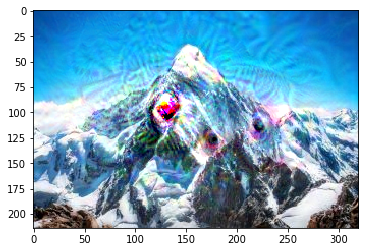

In [174]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()